# Import the dataset

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

<div style = "text-align: justify">The number of images in both <b>color and gray</b> folders is 7129. We will be working only on 40% of images in both the folders, <b>due to hardware constrains.</b> First step is to sort the images in the same order. Then we can rescale them and pass them as numpy arrays.</div>

In [2]:
clr_path = "../input/landscape-image-colorization/landscape Images/color/"
gry_path = "../input/landscape-image-colorization/landscape Images/gray/"

In [3]:
import os

clr_img_path = []
gry_img_path = []

for img_path in os.listdir(clr_path) :
    clr_img_path.append(os.path.join(clr_path, img_path))
    
for img_path in os.listdir(gry_path) :
    gry_img_path.append(os.path.join(gry_path, img_path))

In [4]:
clr_img_path.sort()
gry_img_path.sort()

In [5]:
from PIL import Image
from keras.preprocessing.image import img_to_array

X = []
y = []

for i in range(5000) :
    
    img1 = cv2.cvtColor(cv2.imread(clr_img_path[i]), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(gry_img_path[i]), cv2.COLOR_BGR2RGB)
    
    y.append(img_to_array(Image.fromarray(cv2.resize(img1,(128,128)))))
    X.append(img_to_array(Image.fromarray(cv2.resize(img2,(128,128)))))

In [6]:
X = np.array(X)
y = np.array(y)

In [7]:
print(X.min())
print(X.max())

0.0
255.0


In [8]:
print(y.min())
print(y.max())

0.0
255.0


# Overview of the dataset & Visualizations

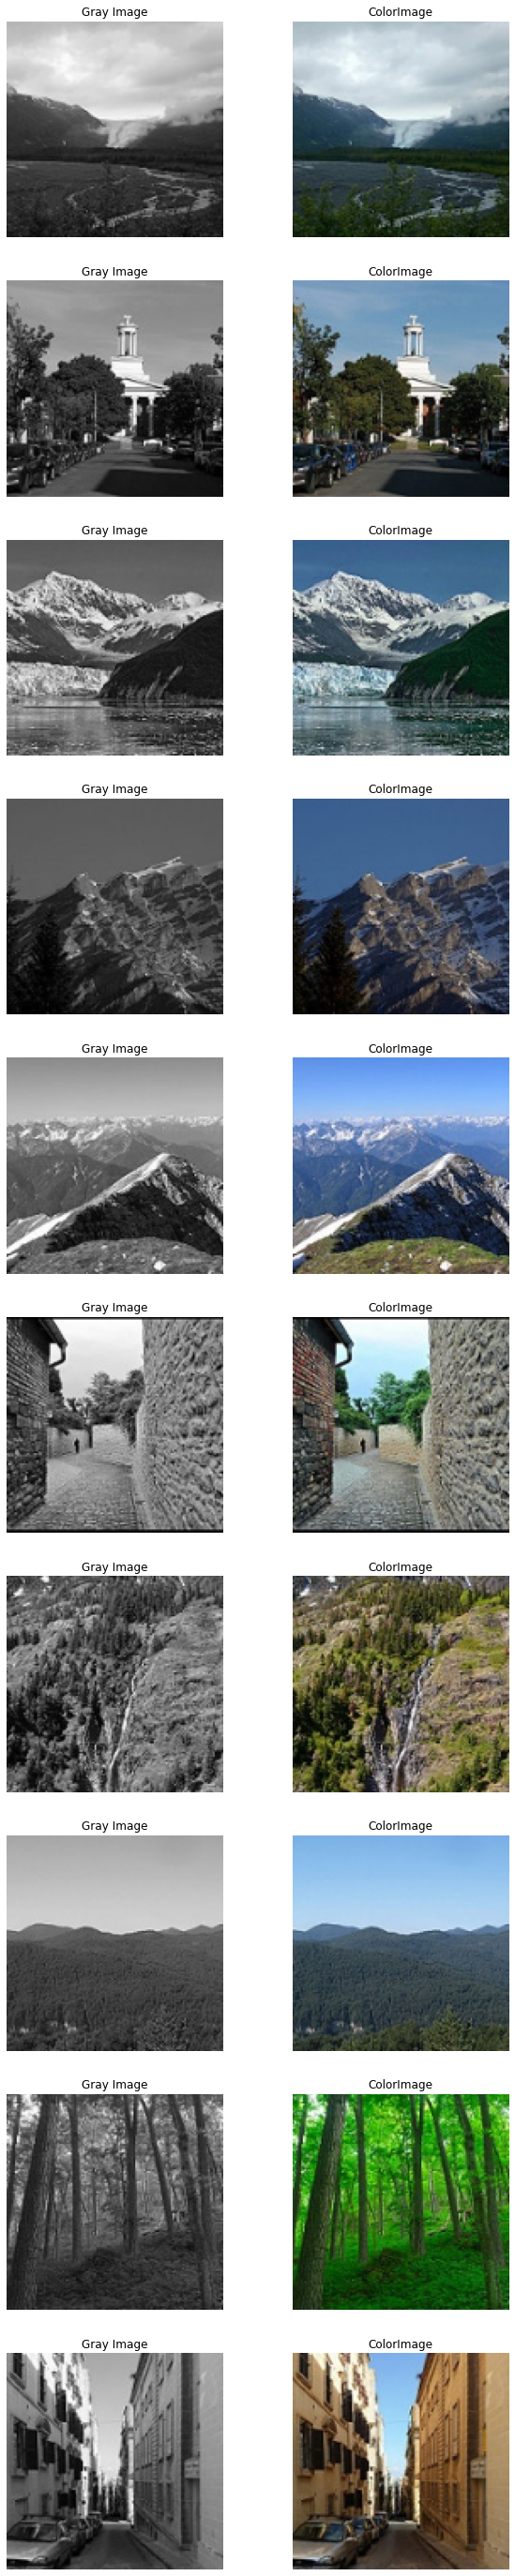

In [9]:
plt.figure(figsize = (10,50))

i = 0

while i < 20:
    
    x = np.random.randint(0,3000)
    
    plt.subplot(10, 2, i+1)
    plt.imshow(X[x]/255.0,'gray')
    plt.axis('off')
    plt.title('Gray Image')
    
    plt.subplot(10, 2, i+2)
    plt.imshow(y[x]/ 255.0)
    plt.axis('off')
    plt.title('ColorImage')
    i += 2
    
plt.show()

In [10]:
X = (X/127.5) - 1
y = (y/127.5) - 1

In [11]:
print(X.shape)
print(y.shape)

(5000, 128, 128, 3)
(5000, 128, 128, 3)


In [12]:
print(f'Minimum of X : {X.min()}')
print(f'Maximum of X : {X.max()}')

Minimum of X : -1.0
Maximum of X : 1.0


In [13]:
print(f'Minimum of y : {y.min()}')
print(f'Maximum of y : {y.max()}')

Minimum of y : -1.0
Maximum of y : 1.0


# Train-test split

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle = False)

In [16]:
print(X_train.shape)
print(y_train.shape)

(4250, 128, 128, 3)
(4250, 128, 128, 3)


In [17]:
print(X_valid.shape)
print(y_valid.shape)

(750, 128, 128, 3)
(750, 128, 128, 3)


In [18]:
img = cv2.imread('../input/modelimage1/1*ETvcPhYH1lCfXndMiKW-jQ.png')

plt.figure(figsize = (20,5))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Different types of normalization techniques (C : Channels | H,W : Spatial dimensions | N : sample space)', fontsize = 15)
plt.axis('off')

error: OpenCV(4.5.1) /tmp/pip-req-build-tk9iuyva/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


<Figure size 1440x360 with 0 Axes>

In [ ]:
from tensorflow_addons.layers import SpectralNormalization
from keras.layers import BatchNormalization
from keras.layers import ZeroPadding2D
from keras.layers import Concatenate
from keras.layers import Activation
from keras.models import Model
from keras.layers import Dense
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Conv2DTranspose
from keras.initializers import RandomNormal
from tensorflow_addons.layers import InstanceNormalization

In [ ]:
'''
Weigth initialization is according to [2], which uses the Gaussian
random distribution with mean of 0 and standard deviation of 0.02.
'''

init = RandomNormal(mean = 0.0, stddev = 0.02)

# PatchGAN (Discriminator)
<div style = "text-align: justify">The PatchGAN discriminator is made up of down sampling blocks <b>d_block(...)</b> where at each step the size of the image is halved and depth is doubled. It comprises of <b>Conv-BatchNorm-LeakyReLU layers</b> with added Spectral normalization <b>[3]</b> and instance normalization <b>[5]</b>. <b>3 such patchGAN models will be used as discriminators </b> and they will be fed images of different resolutions <b>[4].</b></div>

In [ ]:
def d_block (x_input, filters, strides, padding, batch_norm, inst_norm) :
    
    x = Conv2D(filters, (4, 4),
               strides=strides,
               padding=padding,
               use_bias= False,
               kernel_initializer = init)(x_input)
    
    '''
    SpectralNormalization is wrapped around convolution layer.
    Also, Instance  and  Batch Normalization layers are added.
    '''
    
    if batch_norm == True :
        x = BatchNormalization   ()(x)
    if inst_norm  == True :
        x = InstanceNormalization()(x)
    x = LeakyReLU(0.2)(x)
    return x


def u_block (x, skip, filters, strides, padding, batch_norm, inst_norm) :
    
    x = Conv2DTranspose(filters, (4, 4),
                        strides=strides,
                        padding=padding,
                        use_bias= False,
                        kernel_initializer = init)(x)
    
    '''
    All the 3 normalizations applied here as well.
    '''
    
    if batch_norm == True :
        x = BatchNormalization   ()(x)
    if inst_norm  == True :
        x = InstanceNormalization()(x)
    x = ReLU()(x)
    conc_x = Concatenate()([x , skip])
    
    return conc_x

In [ ]:
def PatchGAN (image_shape) :
    
    genI = Input(shape =  image_shape)
    tarI = Input(shape =  image_shape)
    conc = Concatenate()([genI, tarI])
    
    c064 = d_block(conc, 2**6, 2, 'same', False, False)
    c128 = d_block(c064, 2**7, 2, 'same', False, True )
    c256 = d_block(c128, 2**8, 2, 'same', True , False)
    
    temp = ZeroPadding2D()(c256)
    
    c512 = d_block(temp, 2**9, 1,'valid', True , False)
    
    temp = ZeroPadding2D()(c512)
    
    c001 = Conv2D(2**0, (4,4), strides=1, padding = 'valid', activation = 'sigmoid', kernel_initializer=init)(temp)
    
    model = Model(inputs = [genI, tarI], outputs = c001)
    return model

In [ ]:
d_model = PatchGAN((128,128,3,))
d_model.summary()

In [ ]:
from keras.utils import plot_model

### Architecture of the discriminator model

In [ ]:
plot_model(d_model, './d_model.png', show_shapes = True)

# Modified U-net (Generator)
<div style = "text-align: justify">The modified U-net is made up of <b>d_block(...) and u_block(...)</b> for encoding and decoding, respectively. The basic structure of encoding path is <b>Conv-BatchNorm-LeakyReLU (slope = 0.2) layers</b> and that of decoding path is <b>TransposeConv-BatchNorm-ReLU layers</b>. In both cases Spectral Normalization <b>[3]</b> was applied. The Instance Normalization layer <b>[5]</b> was applied for last decoding layer <b>(u064)</b>.</div>

In [ ]:
def mod_Unet () :
    
    srcI = Input(shape = (128,128,3,))
    
    # Contracting path
    
    c064 = d_block(srcI, 2**6, 2, 'same', False, False) # _______________________.
    c128 = d_block(c064, 2**7, 2, 'same', True , False) # ____________________.  .
    c256 = d_block(c128, 2**8, 2, 'same', True , False) # _________________.  .  .
    c512 = d_block(c256, 2**9, 2, 'same', True , False) # ______________.  .  .  .
    d512 = d_block(c512, 2**9, 2, 'same', True , False) # ___________.  .  .  .  .
    e512 = d_block(d512, 2**9, 2, 'same', True , False) # ________.  .  .  .  .  .
                                                        #         .  .  .  .  .  .
    # Bottleneck layer                                            .  .  .  .  .  .
                                                        #         .  .  .  .  .  .
    f512 = d_block(e512, 2**9, 2, 'same', True , False) #         .  .  .  .  .  .
                                                        #         .  .  .  .  .  .
    # Expanding  path                                             .  .  .  .  .  .
                                                        #         .  .  .  .  .  .
    u512 = u_block(f512, e512, 2**9, 2, 'same', True, False)# ____.  .  .  .  .  .
    u512 = u_block(u512, d512, 2**9, 2, 'same', True, False)# _______.  .  .  .  .
    u512 = u_block(u512, c512, 2**9, 2, 'same', True, False)# __________.  .  .  .
    u256 = u_block(u512, c256, 2**8, 2, 'same', True, False)# _____________.  .  .
    u128 = u_block(u256, c128, 2**7, 2, 'same', True, False)# ________________.  .
    u064 = u_block(u128, c064, 2**6, 2, 'same', False, True)# ___________________.
    
    genI = Conv2DTranspose(3, (4,4), strides = 2, padding = 'same', activation = 'tanh', kernel_initializer = init)(u064)
    
    model = Model(inputs = srcI, outputs = genI)
    return model

In [ ]:
g_model = mod_Unet()
g_model.summary()

### Architecture of the generator model

In [ ]:
plot_model(g_model, './g_model.png', show_shapes = True)

# Make tf.datasets

In [ ]:
'''
The information for batch-size appropriate for BW->COLOR transformation
was mentioned as 4 in [1](code source). The optimizer used is Adam with
learningRate of 0.0002, beta1 = 0.5 and beta2 = 0.999 according to [2].
'''

LAMBDA = 100
BATCH_SIZE = 16
BUFFER_SIZE  = 400

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE)
valid_dataset = valid_dataset.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE)

# Load models

In [ ]:
gen0 = mod_Unet()

'''
Using the idea of multi-scale discriminator from [4]. We  use three
discriminators downsampling the input volume by a factor of 2 and 4.
'''

dis0 = PatchGAN((128,128,3,)) # (W//1) x (H//1)
dis1 = PatchGAN((64, 64, 3,)) # (W//2) x (H//2)
dis2 = PatchGAN((32, 32, 3,)) # (W//4) x (H//4)

# Loss functions

In [ ]:
bin_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def gen_loss (dis_gen_output, target_image, gen_output) :
    
    ad_loss = bin_entropy(tf.ones_like (dis_gen_output) ,  dis_gen_output)
    l1_loss = tf.reduce_mean(tf.abs(tf.subtract(target_image,gen_output)))
    
    '''
    Total loss = adversarial +  (LAMBDA*L1)
    '''
    total_loss = ad_loss + (LAMBDA*l1_loss)
    
    return total_loss, ad_loss, l1_loss

In [ ]:
def dis_loss (dis_gen_output, dis_tar_output) :
    
    gen_loss = bin_entropy(tf.zeros_like(dis_gen_output), dis_gen_output)
    tar_loss = bin_entropy(tf.ones_like (dis_tar_output), dis_tar_output)
    
    total_dis_loss = gen_loss + tar_loss
    return total_dis_loss

# Custom Training
<div style = "text-align: justify">First we are going to make the appropriate tensorflow datsets, then we declare the optimizer and checkpoint. Then we implement the training function, where we use <b>Gradient Tape</b> to retrieve the gradients of trackable objects (weights here) with repect to loss function. </div>

### Images of different resolutions

In [ ]:
img  = cv2.imread('../input/landscape-image-colorization/landscape Images/color/10.jpg')
img  = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (128,128))
a128 = img_to_array(Image.fromarray(img))

a128/= 255.0

a064 = cv2.resize(a128, (64,64))
a032 = cv2.resize(a064, (32,32))

In [ ]:
plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
plt.imshow(a128)
plt.title('128x128', fontsize = 20)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(a064)
plt.title('64 x 64', fontsize = 20)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(a032)
plt.title('32 x 32', fontsize = 20)
plt.axis('off')

### Optimizer

In [ ]:
g_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5, beta_2=0.999)
d0optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5, beta_2=0.999)
d1optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5, beta_2=0.999)
d2optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1=0.5, beta_2=0.999)

# Training for each batch

In [ ]:
@tf.function
def train_on_batch (b_w_image, tar_image) :
    
    with tf.GradientTape(persistent = True) as  g :
        
        '''
        Image Tensors
        '''
        gen_image = gen0(b_w_image, training=True)
        
        # 128x128
        dis_tar_output_128 = dis0([b_w_image, tar_image], training = True)
        dis_gen_output_128 = dis0([b_w_image, gen_image], training = True)
        
        
        tar_image_128 = tar_image
        gen_image_128 = gen_image
        
        tar_image = tf.image.resize(tar_image, [64,64])
        b_w_image = tf.image.resize(b_w_image, [64,64])
        gen_image = tf.image.resize(gen_image, [64,64])
        
        # 064x064
        dis_tar_output_064 = dis1([b_w_image, tar_image], training = True)
        dis_gen_output_064 = dis1([b_w_image, gen_image], training = True)
        
        tar_image_064 = tar_image
        gen_image_064 = gen_image
        
        tar_image = tf.image.resize(tar_image, [32,32])
        b_w_image = tf.image.resize(b_w_image, [32,32])
        gen_image = tf.image.resize(gen_image, [32,32])
        
        # 032x032
        dis_tar_output_032 = dis2([b_w_image, tar_image], training = True)
        dis_gen_output_032 = dis2([b_w_image, gen_image], training = True)
        
        tar_image_032 = tar_image
        gen_image_032 = gen_image
        
        '''
        LOSS
        '''
        
        # 128x128
        g_loss_128, _, _ = gen_loss(dis_gen_output_128, tar_image_128, gen_image_128)
        d_loss_128 = dis_loss(dis_gen_output_128, dis_tar_output_128)
        
        # 064x064
        g_loss_064, _, _ = gen_loss(dis_gen_output_064, tar_image_064, gen_image_064)
        d_loss_064 = dis_loss(dis_gen_output_064, dis_tar_output_064)
        
        # 032x032
        g_loss_032, _, _ = gen_loss(dis_gen_output_032, tar_image_032, gen_image_032)
        d_loss_032 = dis_loss(dis_gen_output_032, dis_tar_output_032)
        
        
        g_total_loss = g_loss_128 + g_loss_064 + g_loss_032
        d_total_loss = d_loss_128 + d_loss_064 + d_loss_032
    
    # compute gradients
    g_gradients = g.gradient(g_total_loss, gen0.trainable_variables) # generatorLoss
    
    d0gradients = g.gradient(d_loss_128, dis0.trainable_variables)   # dis loss 128
    d1gradients = g.gradient(d_loss_064, dis1.trainable_variables)   # dis loss 064
    d2gradients = g.gradient(d_loss_032, dis2.trainable_variables)   # dis loss 032
    
    
    # apply gradient descent
    g_optimizer.apply_gradients(zip(g_gradients, gen0.trainable_variables))
    
    d0optimizer.apply_gradients(zip(d0gradients, dis0.trainable_variables))
    d1optimizer.apply_gradients(zip(d1gradients, dis1.trainable_variables))
    d2optimizer.apply_gradients(zip(d2gradients, dis2.trainable_variables))

In [ ]:
for global_b_w_image, global_tar_image in train_dataset.take(1) :
    pass

# fit() method

#### Note
<div style = "text-align: justify">The models have parameter <b>training = True</b> so that the batch statistics are calculated (eg. mean and variance) for the test dataset, and not the statistics from training dataset (in case you put <b>training = False</b>).</div>

In [ ]:
def fig (b_w_image, gen_image, tar_image) :
    
    plt.figure(figsize = (20, 20))
    
    plt.subplot(1,3,1)
    plt.imshow((b_w_image[0] + 1.0) / 2.0)
    plt.title('BandW Image',fontsize = 20)
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow((gen_image[0] + 1.0) / 2.0)
    plt.title('GenerateImg',fontsize = 20)
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow((tar_image[0] + 1.0) / 2.0)
    plt.title('Colored Img',fontsize = 20)
    plt.axis('off')
    
    plt.show()

def fit (EPOCHS = 200) :
    
    for epoch in range(EPOCHS) :
        
        print(f'Epoch {epoch} out of {EPOCHS}')
        
        for n, (b_w_image, tar_image) in train_dataset.enumerate() :
            if n ==  265 :
                print('#....End')
            if n%20 == 0 :
                print('#',end='')
            train_on_batch(b_w_image, tar_image)
        
        if epoch%3  == 0 :
            global_gen_image = gen0(global_b_w_image,training = True)
            fig(global_b_w_image, global_gen_image, global_tar_image)

# Model Training

In [ ]:
fit(EPOCHS = 100)

In [ ]:
import pickle

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

# Model Prediction

In [ ]:
for b_w_image,tar_image in valid_dataset.take(20) :
    gen_image = gen0(b_w_image , training = True)
    fig(b_w_image, gen_image, tar_image)

### All models are saved

In [ ]:
gen0.save('./gen0.h5')
dis0.save('./dis0.h5')
dis1.save('./dis1.h5')
dis2.save('./dis2.h5')

In [ ]:
imgg_path='../input/sooraj/sooraj_black_white.jpg'

In [ ]:
img1 = cv2.cvtColor(cv2.imread(imgg_path), cv2.COLOR_BGR2RGB)

In [ ]:
img2=img_to_array(Image.fromarray(cv2.resize(img1,(128,128))))

In [ ]:
img3 = np.array(img2)

In [ ]:
img4 = (img3/127.5) - 1

In [ ]:
img4.shape

In [ ]:
img5=img4.reshape(1,128,128,3)

In [ ]:
plt.figure(figsize = (10,50))
plt.subplot(10, 2,1)
plt.imshow(img4,'gray')
plt.axis('off')
plt.title('Gray Image')
plt.show()

In [ ]:
gen_image = gen0(img5 , training = False)
fig(img5, gen_image, img4)

In [ ]:
!pip install tensorflowjs > /dev/null 2>&1

import tensorflowjs
print(tensorflowjs.__version__)

# convert keras model to tensorflow js
tensorflowjs.converters.save_keras_model(gen0, '/kaggle/working')